In [2]:
from __future__ import division
import numpy as np
import xgboost as xgb
import pandas as pd
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as op
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import randint, uniform
from pdb import set_trace

### Weight function (depreciated)

In [10]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights

### Confusion matrix and individual class matrix function

In [3]:
def confusio_matrix(y_test, y_predicted):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(8,4))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Cytosol', 'Mitochondria', 'Nuclear', 'Secretory']
  plt.title('Confusion Matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  
  for i in range(len(classNames)):
      for j in range(len(classNames)):
          plt.text(j,i,str(cm[i][j]), ha='center', va='center')
  plt.show()

def making_ind_confusio_matrix(title, count, percent, accur, preci, sens, spec, f1):
    plt.figure(figsize=(2,2))
    plt.clf()
    plt.imshow(count, interpolation='none', cmap=plt.cm.Wistia)
    classNames = ['True', 'False']
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
  
    for i in range(len(classNames)):
        for j in range(len(classNames)):
            s = str(count[i][j]) + '\n' + str(percent[i][j])
            plt.text(j,i,s, ha='center', va='center')
    plt.text(1.8, 0.5, 
             f'Accuracy: {accur}\nPrecision: {preci}\nSensitivity: {sens}\nSpecificty: {spec}\nF1 Score: {f1}')
    plt.show()
    
def cytosol_confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    
    # tallying 
    TP = cm[0][0]
    FP = cm[1][0]+cm[2][0]+cm[3][0]
    FN = cm[0][1]+cm[0][2]+cm[0][3]
    TN = cm[1][1]+cm[1][2]+cm[1][3]+cm[2][1]+cm[2][2]+cm[2][3]+cm[3][1]+cm[3][2]+cm[3][3]
    assem_count = np.array([TP,FP,FN,TN]).reshape(2,2)
    total = sum(sum(cm))
    assem_percent = np.array([round((TP/total)*100, 2), round((FP/total)*100,2), round((FN/total)*100,2), round((TN/total)*100,2)]).reshape(2,2)
    
    # sensitivity and specificity
    sense = round((TP / (TP + FN)),2)
    speci = round((TN / (TN + FP)),2)
    accuracy = round(((TP + TN)/ total),2)
    precision = round((TP / (TP + FP)),2)
    f1_score = round((2/(1/precision + 1/sense)),2)
    
    making_ind_confusio_matrix('Cytosol', assem_count, assem_percent, accuracy, precision, sense, speci, f1_score)
    
def mito_confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    
    # tallying 
    TP = cm[1][1]
    FP = cm[1][0]+cm[1][2]+cm[1][3]
    FN = cm[1][0]+cm[1][2]+cm[1][3]
    TN = cm[0][0]+cm[0][2]+cm[0][3]+cm[2][0]+cm[2][2]+cm[2][3]+cm[3][0]+cm[3][2]+cm[3][3]
    assem_count = np.array([TP,FP,FN,TN]).reshape(2,2)
    total = sum(sum(cm))
    assem_percent = np.array([round((TP/total)*100, 2), round((FP/total)*100,2), round((FN/total)*100,2), round((TN/total)*100,2)]).reshape(2,2)
    
    # sensitivity and specificity
    sense = round((TP / (TP + FN)),2)
    speci = round((TN / (TN + FP)),2)
    accuracy = round(((TP + TN)/ total),2)
    precision = round((TP / (TP + FP)),2)
    f1_score = round((2/(1/precision + 1/sense)),2)
    
    making_ind_confusio_matrix('Mitochondria', assem_count, assem_percent, accuracy, precision, sense, speci, f1_score)

def nuclear_confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    
    # tallying 
    TP = cm[2][2]
    FP = cm[0][2]+cm[1][2]+cm[3][2]
    FN = cm[2][0]+cm[2][1]+cm[2][3]
    TN = cm[0][0]+cm[0][1]+cm[0][3]+cm[1][0]+cm[1][1]+cm[1][3]+cm[3][0]+cm[3][1]+cm[3][3]
    assem_count = np.array([TP,FP,FN,TN]).reshape(2,2)
    total = sum(sum(cm))
    assem_percent = np.array([round((TP/total)*100, 2), round((FP/total)*100,2), round((FN/total)*100,2), round((TN/total)*100,2)]).reshape(2,2)
    
    # sensitivity and specificity
    sense = round((TP / (TP + FN)),2)
    speci = round((TN / (TN + FP)),2)
    accuracy = round(((TP + TN)/ total),2)
    precision = round((TP / (TP + FP)),2)
    f1_score = round((2/(1/precision + 1/sense)),2)
    
    making_ind_confusio_matrix('Nuclear', assem_count, assem_percent, accuracy, precision, sense, speci, f1_score)
   
def secret_confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    
    # tallying 
    TP = cm[3][3]
    FP = cm[0][3]+cm[1][3]+cm[2][3]
    FN = cm[3][0]+cm[3][1]+cm[3][2]
    TN = cm[0][0]+cm[0][1]+cm[0][2]+cm[1][0]+cm[1][1]+cm[1][2]+cm[2][0]+cm[2][1]+cm[2][2]
    assem_count = np.array([TP,FP,FN,TN]).reshape(2,2)
    total = sum(sum(cm))
    assem_percent = np.array([round((TP/total)*100, 2), round((FP/total)*100,2), round((FN/total)*100,2), round((TN/total)*100,2)]).reshape(2,2)
    
    # sensitivity and specificity
    sense = round((TP / (TP + FN)),2)
    speci = round((TN / (TN + FP)),2)
    accuracy = round(((TP + TN)/ total),2)
    precision = round((TP / (TP + FP)),2)
    f1_score = round((2/(1/precision + 1/sense)),2)
    
    making_ind_confusio_matrix('Secretory', assem_count, assem_percent, accuracy, precision, sense, speci, f1_score)

### Krug Data processing

In [4]:
# load training dataset
train = pd.read_csv('krug_train_0425.csv')

# excluding "unclassified" gene
train = train[train['Localization']!='Unclassified']

# drop index and gene column
train.drop(columns=['Unnamed: 0','Gene'],inplace=True)
print("Shape of complete dataframe:", train.shape)

# check target class and number
Counter(train['Localization'])

# assign independent variables as X and target as Y
X = train.drop(columns='Localization')
Y = train['Localization']

# encode target
Y = LabelEncoder().fit_transform(Y)

# sanity check to see numbers match and matching with previous counter to create target dictionary
print(Counter(train['Localization']))
print(Counter(Y))
target_dict = {'Cytosol':0, 'Mitochondria':1, 'Nuclear':2, 'Secretory':3, 'Unclassified':4}

# train-valid split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.30, random_state=0)

# sanity check
for i in [X_train, X_val, y_train, y_val]:
    print(i.shape)

Shape of complete dataframe: (7167, 252)
Counter({'Cytosol': 3068, 'Nuclear': 1989, 'Secretory': 1602, 'Mitochondria': 508})
Counter({0: 3068, 2: 1989, 3: 1602, 1: 508})
(5016, 251)
(2151, 251)
(5016,)
(2151,)


### Johansson Data processing

In [7]:
# load training dataset
train2 = pd.read_csv('jo_train_0502.csv')

# excluding "unclassified" gene
train2 = train2[train2['Localization']!='Unclassified']

# drop index and gene columns
train2.drop(columns=['Unnamed: 0','Gene'],inplace=True)
print("Shape of complete dataframe:", train2.shape)

# check target class and number
Counter(train2['Localization'])

# assign independent variables as X and target as Y
X2 = train2.drop(columns='Localization')
Y2 = train2['Localization']

# encode target
Y2 = LabelEncoder().fit_transform(Y2)

# sanity check to see numbers match and matching with previous counter to create target dictionary
print(Counter(train2['Localization']))
print(Counter(Y2))
target_dict = {'Cytosol':0, 'Mitochondria':1, 'Nuclear':2, 'Secretory':3}

# train-valid split
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, Y2, test_size=0.30, random_state=1)

for i in [X2_train, X2_val, y2_train, y2_val]:
    print(i.shape)

Shape of complete dataframe: (8546, 98)
Counter({'Cytosol': 3364, 'Nuclear': 2402, 'Secretory': 2228, 'Mitochondria': 552})
Counter({0: 3364, 2: 2402, 3: 2228, 1: 552})
(5982, 97)
(2564, 97)
(5982,)
(2564,)


### Mix Data processing

In [5]:
# load training dataset
train3 = pd.read_csv('mix_train_0502.csv')

# excluding "unclassified" gene
train3 = train3[train3['Localization']!='Unclassified']

# drop index and gene columns
train3.drop(columns=['Unnamed: 0','Gene'],inplace=True)
print("Shape of complete dataframe:", train3.shape)

# check target class and number
Counter(train3['Localization'])

# assign independent variables as X and target as Y
X3 = train3.drop(columns='Localization')
Y3 = train3['Localization']

# encode target
Y3 = LabelEncoder().fit_transform(Y3)

# sanity check to see numbers match and matching with previous counter to create target dictionary
print(Counter(train3['Localization']))
print(Counter(Y3))
target_dict = {'Cytosol':0, 'Mitochondria':1, 'Nuclear':2, 'Secretory':3}

# train-valid split
X3_train, X3_val, y3_train, y3_val = train_test_split(X3, Y3, test_size=0.30, random_state=1)

# sanity check
for i in [X3_train, X3_val, y3_train, y3_val]:
    print(i.shape)

Shape of complete dataframe: (7094, 342)
Counter({'Cytosol': 3038, 'Nuclear': 1964, 'Secretory': 1587, 'Mitochondria': 505})
Counter({0: 3038, 2: 1964, 3: 1587, 1: 505})
(4965, 341)
(2129, 341)
(4965,)
(2129,)


### XGboost Modeling (Krug)

In [6]:
# create weights to compensate the imbalanced labels
# train_most_count = Counter(y_train).most_common(1)
# train_largest_class_weight_coef = train_most_count[0][1]/len(y_train)

# valid_most_count = Counter(y_val).most_common(1)
# valid_largest_class_weight_coef = valid_most_count[0][1]/len(y_val)

# train_weight = CreateBalancedSampleWeights(y_train, train_largest_class_weight_coef)
# valid_weight = CreateBalancedSampleWeights(y_val, valid_largest_class_weight_coef)

# calculate weight with sklearn compute_sample_weight
train_weight = compute_sample_weight('balanced', y_train)
valid_weight = compute_sample_weight('balanced', y_val)

# label the data matrix (similar to dataloader)
xg_train = xgb.DMatrix(X_train, label=y_train, weight=train_weight, nthread=-1)
xg_valid = xgb.DMatrix(X_val, label=y_val, weight=valid_weight, nthread=-1)

# setup parameters for xgboost
param = {
    'objective': 'multi:softmax',
    'eval_metric': ['mlogloss'],
    'num_class': 4, # change this when you exclude 'unclassified'
    'max_depth': 10, # Maximum depth of a tree [0, +inf]
    'max_delta_step': 1, # Maximum delta step we allow each leaf output to be; this helps if class is imbalanced
    'eta': 0.0599,  #learning rate, range [0,1]
    'alpha': 6,
    'lambda': 8,
    'gamma': 1, # regularization hyperparameter; tuneable
    'subsample': 0.3795, # randomly sample X percent of the training data prior to growing trees.
    'sampling_method': 'gradient_based', # avail only tree method is gpu_hist
    'colsample_bytree': 0.83, # subsample ratio of columns when constructing each tree
    'tree_method': 'gpu_hist', # Use GPU for faster training
            }

watchlist = [(xg_train, 'training'), (xg_valid, 'validation')]

bst = xgb.train(
                params = param, 
                dtrain = xg_train,
                num_boost_round = 500,
                evals = watchlist,
                early_stopping_rounds=10,
                verbose_eval=50)

[0]	training-mlogloss:1.34311	validation-mlogloss:1.35369
[50]	training-mlogloss:0.45563	validation-mlogloss:0.74749
[100]	training-mlogloss:0.29480	validation-mlogloss:0.66740
[150]	training-mlogloss:0.23046	validation-mlogloss:0.64259
[200]	training-mlogloss:0.19580	validation-mlogloss:0.63367
[250]	training-mlogloss:0.17501	validation-mlogloss:0.62967
[300]	training-mlogloss:0.16240	validation-mlogloss:0.62719
[350]	training-mlogloss:0.15482	validation-mlogloss:0.62482
[400]	training-mlogloss:0.15039	validation-mlogloss:0.62296
[450]	training-mlogloss:0.14745	validation-mlogloss:0.62213
[455]	training-mlogloss:0.14714	validation-mlogloss:0.62217


### Feature importances inspection (Krug)

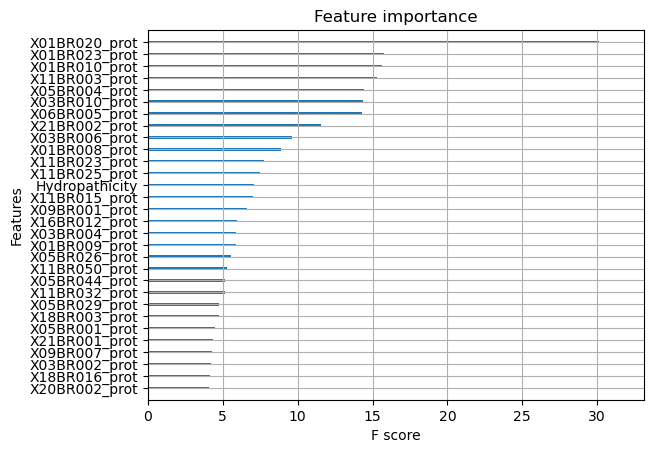

In [12]:
# Get feature importance
importance = bst.get_score(importance_type='weight')
# 'weight' denotes the number of times a feature is used to split the data across all trees.

# Print feature importance
#print(importance)

# Plot feature importance
xgb.plot_importance(bst, max_num_features=30, importance_type='gain', show_values=False)
plt.show()

### Prediction and confusion matrices (Krug)

Test error using softmax = 0.18410041841004185
Test accuracy: 0.8158995815899581


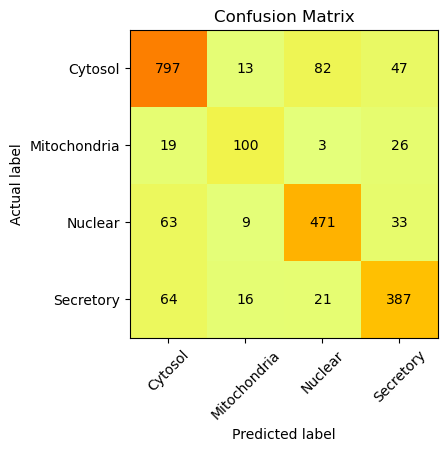

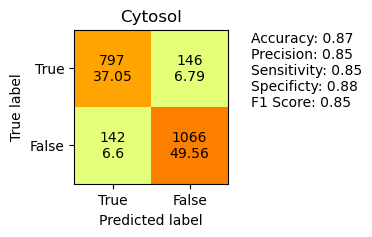

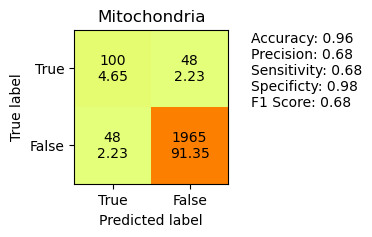

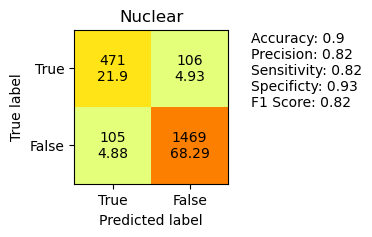

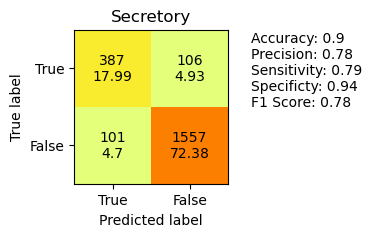

In [7]:
# get prediction
pred = bst.predict(xg_valid)
if param['objective'] == 'multi:softprob':
    max_prob_index=[]
    for i in range(len(pred)):
        gene = list(pred[i])
        max_prob_index.append(gene.index(max(gene)))
    pred = np.array(max_prob_index)
    error_rate = np.sum(pred != y_val) / y_val.shape[0]
    print('Test error using softprob = {}'.format(error_rate))
    accuracy = sum(pred == y_val) / len(y_val)
    print(f'Test accuracy: {accuracy}')
else:
    error_rate = np.sum(pred != y_val) / y_val.shape[0]
    print('Test error using softmax = {}'.format(error_rate))
    accuracy = sum(pred == y_val) / len(y_val)
    print(f'Test accuracy: {accuracy}')
    
# get overall confusion matrix
confusio_matrix(y_val, pred)
cytosol_confusio_matrix(y_val, pred)
mito_confusio_matrix(y_val, pred)
nuclear_confusio_matrix(y_val, pred)
secret_confusio_matrix(y_val, pred)

### XGboost Modeling (Johansson)

In [14]:
# create weights to compensate the imbalanced labels
# train2_most_count = Counter(y2_train).most_common(1)
# train2_largest_class_weight_coef = train2_most_count[0][1]/len(y2_train)

# valid2_most_count = Counter(y2_val).most_common(1)
# valid2_largest_class_weight_coef = valid2_most_count[0][1]/len(y2_val)

# train_weight2 = CreateBalancedSampleWeights(y2_train, train2_largest_class_weight_coef)
# valid_weight2 = CreateBalancedSampleWeights(y2_val, valid2_largest_class_weight_coef)

# calculate weight with sklearn compute_sample_weight
train_weight2 = compute_sample_weight('balanced', y2_train)
valid_weight2 = compute_sample_weight('balanced', y2_val)

# label the data matrix (similar to dataloader)
xg2_train = xgb.DMatrix(X2_train, label=y2_train, weight = train_weight2, nthread=-1)
xg2_valid = xgb.DMatrix(X2_val, label=y2_val, weight = valid_weight2, nthread=-1)

# setup parameters for xgboost
param = {
    'objective': 'multi:softmax',
    'eval_metric': ['mlogloss'],
    'num_class': 4, # change this when you exclude 'unclassified'
    'max_depth': 7, # Maximum depth of a tree [0, +inf]
    'max_delta_step': 10, # Maximum delta step we allow each leaf output to be; this helps if class is imbalanced
    'eta': 0.05,  #learning rate, range [0,1]
    'alpha': 7,
    'lambda': 7,
    'gamma': 1, # regularization hyperparameter; tuneable
    'subsample': 0.5, # randomly sample X percent of the training data prior to growing trees.
    'sampling_method': 'gradient_based', # avail only tree method is gpu_hist
    'colsample_bytree': 0.5, # subsample ratio of columns when constructing each tree
    'tree_method': 'gpu_hist', # Use GPU for faster training
            }

watchlist2 = [(xg2_train, 'training'), (xg2_valid, 'validation')]

bst2 = xgb.train(
                params = param, 
                dtrain = xg2_train,
                num_boost_round = 800,
                evals = watchlist2,
                early_stopping_rounds=10,
                verbose_eval=50)

[0]	training-mlogloss:1.35604	validation-mlogloss:1.36102
[50]	training-mlogloss:0.76289	validation-mlogloss:0.91631
[100]	training-mlogloss:0.58912	validation-mlogloss:0.81445
[150]	training-mlogloss:0.50151	validation-mlogloss:0.77263
[200]	training-mlogloss:0.44495	validation-mlogloss:0.75110
[250]	training-mlogloss:0.40619	validation-mlogloss:0.73882
[300]	training-mlogloss:0.37722	validation-mlogloss:0.73164
[350]	training-mlogloss:0.35667	validation-mlogloss:0.72691
[400]	training-mlogloss:0.34348	validation-mlogloss:0.72498
[450]	training-mlogloss:0.33547	validation-mlogloss:0.72354
[500]	training-mlogloss:0.32937	validation-mlogloss:0.72285
[549]	training-mlogloss:0.32507	validation-mlogloss:0.72222


### Feature importances inspection (Johansson)

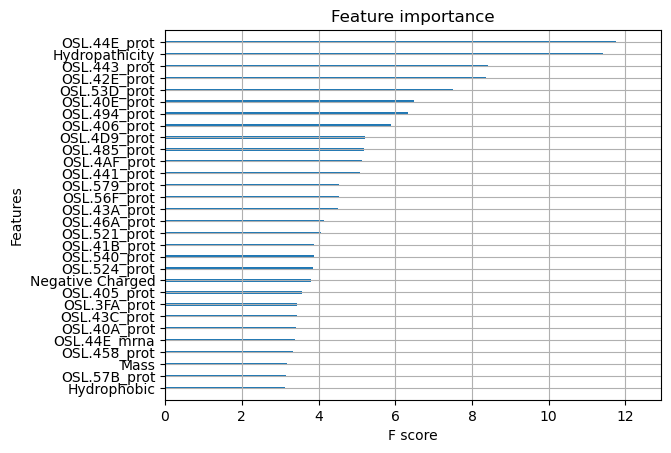

In [15]:
# Get feature importance
importance = bst2.get_score(importance_type='weight')
# 'weight' denotes the number of times a feature is used to split the data across all trees.

# Print feature importance
#print(importance)

# Plot feature importance
xgb.plot_importance(bst2, max_num_features=30, importance_type='gain', show_values=False)
plt.show()

### Prediction and confusion matrices (Johansson)

Accuracy: 0.723


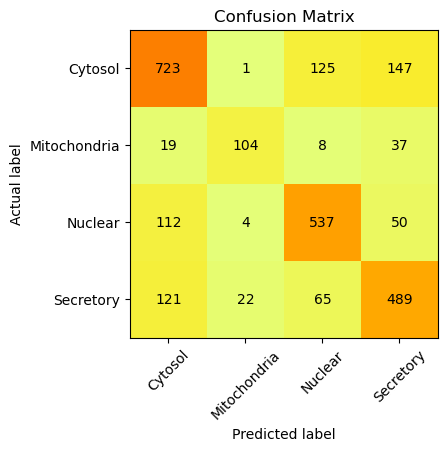

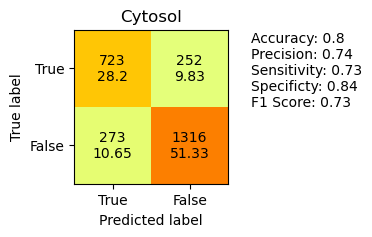

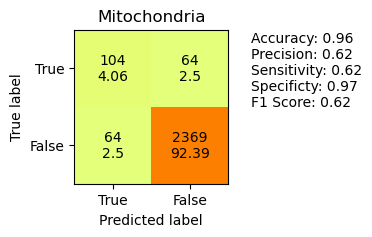

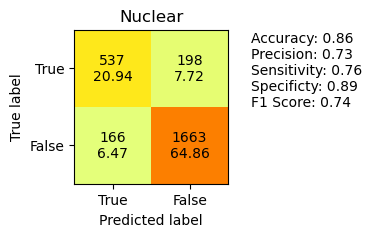

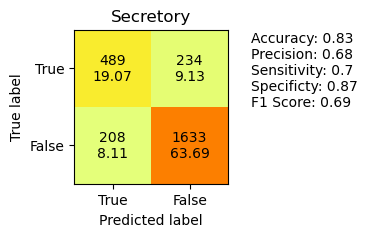

In [16]:
# get prediction
yhat2 = bst2.predict(xg2_valid)
if param['objective'] == 'multi:softprob':
    max_prob_index=[]
    for i in range(len(yhat2)):
        gene = list(yhat2[i])
        max_prob_index.append(gene.index(max(gene)))
    pred2 = np.array(max_prob_index)
    error_rate = np.sum(pred2 != y2_val) / y2_val.shape[0]
    print('Test error using softprob = {}'.format(error_rate))
    accuracy = sum(pred2 == y2_val) / len(y2_val)
    print(f'Test accuracy: {accuracy}')
else:
    score = accuracy_score(y2_val, yhat2)
    print('Accuracy: %.3f' % score)
    
# get overall confusion matrix
confusio_matrix(y2_val, yhat2)
cytosol_confusio_matrix(y2_val, yhat2)
mito_confusio_matrix(y2_val, yhat2)
nuclear_confusio_matrix(y2_val, yhat2)
secret_confusio_matrix(y2_val, yhat2)

### XGboost Modeling (Mix)

In [8]:
# create weights to compensate the imbalanced labels
# train_most_count = Counter(y3_train).most_common(1)
# train_largest_class_weight_coef = train_most_count[0][1]/len(y3_train)

# valid_most_count = Counter(y3_val).most_common(1)
# valid_largest_class_weight_coef = valid_most_count[0][1]/len(y3_val)

# train_weight3 = CreateBalancedSampleWeights(y3_train, train_largest_class_weight_coef)
# valid_weight3 = CreateBalancedSampleWeights(y3_val, valid_largest_class_weight_coef)

# calculate weight with sklearn compute_sample_weight
train_weight3 = compute_sample_weight('balanced', y3_train)
valid_weight3 = compute_sample_weight('balanced', y3_val)

# label the data matrix (similar to dataloader)
xg3_train = xgb.DMatrix(X3_train, label=y3_train, weight=train_weight3)
xg3_valid = xgb.DMatrix(X3_val, label=y3_val, weight=valid_weight3)

# setup parameters for xgboost
param = {
    'objective': 'multi:softmax',
    'eval_metric': ['merror', 'mlogloss'],
    'num_class': 4, # change this when you exclude 'unclassified'
    'max_depth': 7, # Maximum depth of a tree [0, +inf]
    'max_delta_step': 10, # Maximum delta step we allow each leaf output to be; this helps if class is imbalanced
    'eta': 0.05,  #learning rate, range [0,1]
    'alpha': 7,
    'lambda': 7,
    'gamma': 1, # regularization hyperparameter; tuneable
    'subsample': 0.5, # randomly sample X percent of the training data prior to growing trees.
    'sampling_method': 'gradient_based', # avail only tree method is gpu_hist
    'colsample_bytree': 0.5, # subsample ratio of columns when constructing each tree
    'tree_method': 'gpu_hist', # Use GPU for faster training
}

watchlist3 = [(xg3_train, 'training'), (xg3_valid, 'validation')]

bst3 = xgb.train(
                params = param, 
                dtrain = xg3_train,
                num_boost_round = 800,
                evals = watchlist3,
                early_stopping_rounds=10,
                verbose_eval=50)

[0]	training-merror:0.23029	training-mlogloss:1.34202	validation-merror:0.38498	validation-mlogloss:1.35478
[50]	training-merror:0.08199	training-mlogloss:0.53714	validation-merror:0.23939	validation-mlogloss:0.77254
[100]	training-merror:0.05868	training-mlogloss:0.35886	validation-merror:0.22286	validation-mlogloss:0.66754
[150]	training-merror:0.04567	training-mlogloss:0.28323	validation-merror:0.22001	validation-mlogloss:0.63359
[200]	training-merror:0.03703	training-mlogloss:0.24108	validation-merror:0.21759	validation-mlogloss:0.61736
[250]	training-merror:0.03117	training-mlogloss:0.21506	validation-merror:0.21504	validation-mlogloss:0.60859
[300]	training-merror:0.02598	training-mlogloss:0.19711	validation-merror:0.21183	validation-mlogloss:0.60289
[350]	training-merror:0.02292	training-mlogloss:0.18412	validation-merror:0.21611	validation-mlogloss:0.59983
[400]	training-merror:0.02096	training-mlogloss:0.17627	validation-merror:0.21662	validation-mlogloss:0.59748
[450]	trainin

### Feature importances inspection (Mix)

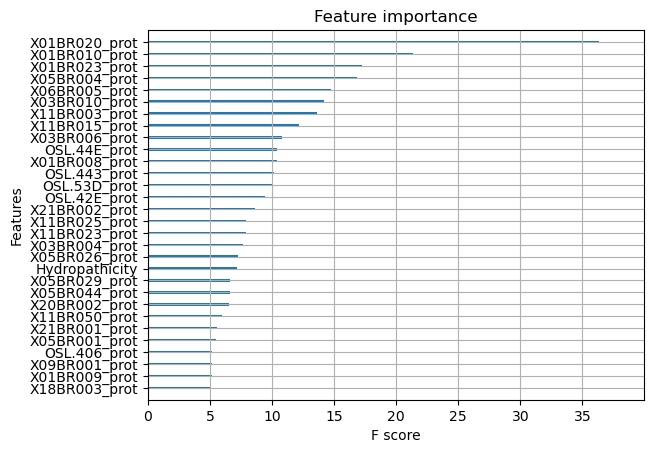

In [18]:
# Get feature importance
importance = bst3.get_score(importance_type='weight')
# 'weight' denotes the number of times a feature is used to split the data across all trees.

# Print feature importance
# print(importance)

# Plot feature importance
xgb.plot_importance(bst3, max_num_features=30, importance_type='gain', show_values=False)
plt.show()

### K-fold validation (Mix)

In [19]:
# Define K-fold cross-validation
cv_results = xgb.cv(params=param, dtrain=xg3_train, nfold=5,
                    num_boost_round=50, 
                    early_stopping_rounds=10, as_pandas=True, seed=123)

In [20]:
cv_results

,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.263019,0.005207,1.347204,0.000652,0.382243,0.020977,1.355169,0.000960
1,0.218945,0.003684,1.311779,0.000862,0.335593,0.014921,1.327423,0.002027
2,0.188601,0.004864,1.277207,0.001037,0.303687,0.015625,1.299681,0.002928
3,0.177309,0.004251,1.244942,0.001270,0.296924,0.012839,1.274206,0.003572
4,0.169217,0.003091,1.213959,0.001380,0.286587,0.016176,1.248516,0.004516
5,0.162374,0.002085,1.184423,0.001323,0.283899,0.016734,1.225007,0.004752
6,0.156043,0.002847,1.155967,0.001292,0.276966,0.016658,1.202355,0.005664
7,0.152584,0.002777,1.128785,0.001058,0.273235,0.015092,1.180856,0.006134
8,0.151936,0.002567,1.103025,0.001266,0.270983,0.016621,1.160303,0.006654
9,0.149397,0.003311,1.078974,0.001197,0.271623,0.017324,1.140985,0.007149


### Prediction and confusion matrices (Mix)

Accuracy: 0.815


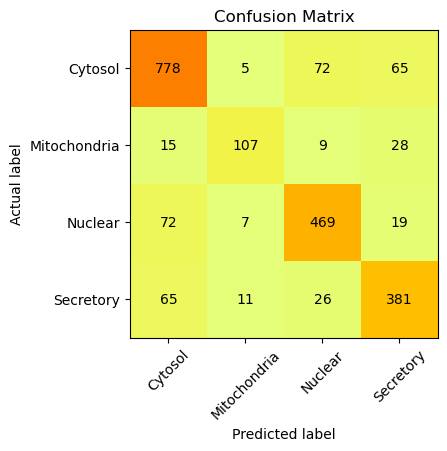

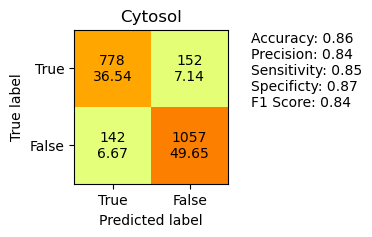

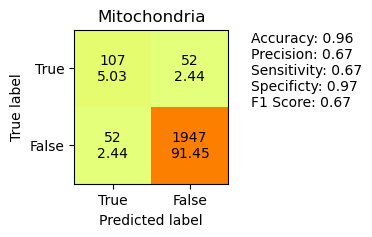

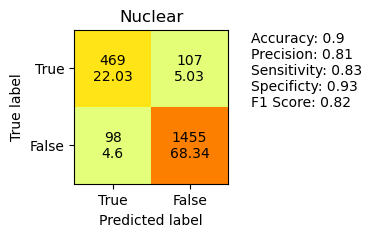

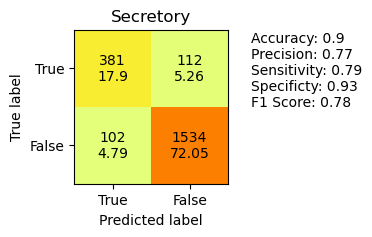

In [9]:
# get prediction
yhat3 = bst3.predict(xg3_valid)
if param['objective'] == 'multi:softprob':
    max_prob_index=[]
    for i in range(len(yhat3)):
        gene = list(pred3[i])
        max_prob_index.append(gene.index(max(gene)))
    pred3 = np.array(max_prob_index)
    error_rate = np.sum(pred3 != y3_val) / y3_val.shape[0]
    print('Test error using softprob = {}'.format(error_rate))
    accuracy = sum(pred3 == y3_val) / len(y3_val)
    print(f'Test accuracy: {accuracy}')
else:
    score = accuracy_score(y3_val, yhat3)
    print('Accuracy: %.3f' % score)
    
confusio_matrix(y3_val, yhat3)
cytosol_confusio_matrix(y3_val, yhat3)
mito_confusio_matrix(y3_val, yhat3)
nuclear_confusio_matrix(y3_val, yhat3)
secret_confusio_matrix(y3_val, yhat3)

### Random search to find best params

In [ ]:
param = {
    'objective': 'multi:softmax',
    'eval_metric': ['merror', 'mlogloss'],
    'num_class': 4, # change this when you exclude 'unclassified'
    'max_depth': 7, # Maximum depth of a tree [0, +inf]
    'max_delta_step': 10, # Maximum delta step we allow each leaf output to be; this helps if class is imbalanced
    'eta': 0.05,  #learning rate, range [0,1]
    'alpha': 7,
    'lambda': 7,
    'gamma': 1, # regularization hyperparameter; tuneable
    'subsample': 0.5, # randomly sample X percent of the training data prior to growing trees.
    'sampling_method': 'gradient_based', # avail only tree method is gpu_hist
    'colsample_bytree': 0.5, # subsample ratio of columns when constructing each tree
    'tree_method': 'gpu_hist', # Use GPU for faster training
}

In [113]:
# Define hyperparameters and their distributions
params_dist = {
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.001, 0.1),
    'n_estimators': randint(100, 500),
    'max_delta_step':randint(0,10),
    'alpha': randint(0,10),
    'lambda': randint(0,10),
    'gamma': randint(0,10),
    'subsample': uniform(0.1, 0.9),
    'colsample_bytree': uniform(0.1, 0.9)
}

# Create XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax')

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(model, params_dist, n_iter=10, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X3_train, y3_train, sample_weight=train_weight3)

# Print the best hyperparameters
print(random_search.best_params_)


{'alpha': 5, 'colsample_bytree': 0.5802306402661898, 'gamma': 1, 'lambda': 4, 'learning_rate': 0.025808395898781047, 'max_delta_step': 4, 'max_depth': 10, 'n_estimators': 447, 'subsample': 0.5301011629604262}


In [114]:
# create weights to compensate the imbalanced labels
train_most_count = Counter(y_train).most_common(1)
train_largest_class_weight_coef = most_count[0][1]/len(y_train)
train_weight = CreateBalancedSampleWeights(y_train, train_largest_class_weight_coef)

train2_most_count = Counter(y2_train).most_common(1)
train2_largest_class_weight_coef = most_count[0][1]/len(y2_train)
train2_weight = CreateBalancedSampleWeights(y2_train, train2_largest_class_weight_coef)


In [115]:
# Define hyperparameters and their distributions
params_dist = {
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.001, 0.1),
    'n_estimators': randint(100, 500),
    'max_delta_step':randint(0,10),
    'alpha': randint(0,10),
    'lambda': randint(0,10),
    'gamma': randint(0,10),
    'subsample': uniform(0.1, 0.9),
    'colsample_bytree': uniform(0.1, 0.9)
}

# Create XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax')

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(model, params_dist, n_iter=10, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X2_train, y2_train, sample_weight=train2_weight)

# Print the best hyperparameters
print(random_search.best_params_)


{'alpha': 2, 'colsample_bytree': 0.9975482088577049, 'gamma': 3, 'lambda': 2, 'learning_rate': 0.03519368966265978, 'max_delta_step': 8, 'max_depth': 3, 'n_estimators': 258, 'subsample': 0.11615278604601968}


In [116]:
# Define hyperparameters and their distributions
params_dist = {
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.001, 0.1),
    'n_estimators': randint(100, 500),
    'max_delta_step':randint(0,10),
    'alpha': randint(0,10),
    'lambda': randint(0,10),
    'gamma': randint(0,10),
    'subsample': uniform(0.1, 0.9),
    'colsample_bytree': uniform(0.1, 0.9)
}

# Create XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax')

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(model, params_dist, n_iter=10, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train, sample_weight=train_weight)

# Print the best hyperparameters
print(random_search.best_params_)

{'alpha': 6, 'colsample_bytree': 0.8309451265923726, 'gamma': 1, 'lambda': 8, 'learning_rate': 0.05988936453962129, 'max_delta_step': 1, 'max_depth': 10, 'n_estimators': 430, 'subsample': 0.37951128034680104}


### Sklearn + XGBoost

In [ ]:
def fitXgb(sk_model, train_data=X_train, train_labels=y_train, valid_data=X_val, valid_labels=y_val, epochs=300):
    print('Fitting model...')
    sk_model.fit(train_data, train_labels.reshape(train_labels.shape[0],))
    print('Fitting done!')
    train = xgb.DMatrix(train_data, label=train_labels)
    val = xgb.DMatrix(valid_data, label=valid_labels)
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = watchlist
    xgb_model = xgb.train(params, train, epochs, evallist, evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(valid_data), valid_labels)))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(train_data),train_labels,average='micro')))
    plot_compare(metrics,store,epochs)

In [ ]:
def plot_compare(metrics, eval_results, epochs):
    for m in metrics:
        test_score = eval_results['validation'][m]
        train_score = eval_results['training'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()

In [ ]:
# from xgboost.sklearn import XGBClassifier
# from sklearn.metrics import accuracy_score, f1_score
# #initial model
# xgb1 = XGBClassifier(learning_rate=0.1,
#                     max_depth=30,
#                     min_child_weight=1,
#                     gamma=0.3,
#                     subsample=0.8,
#                     colsample_bytree=0.8,
#                     objective='multi:softmax',
#                     nthread=4,
#                     num_class=5)

In [ ]:
#fitXgb(xgb1, train_data=X_train, train_labels=y_train, valid_data=X_val, valid_labels=y_val)